> Ref from https://colab.research.google.com/drive/14ncV0nviLcP9IDzmFSRGSXb7Bgpz212v#scrollTo=1AJoWmexhbUQ

In [1]:
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

# This will be a tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

def divide(a: int, b: int) -> float:
    """Divide a and b.

    Args:
        a: first int
        b: second int
    """
    return a / b

from langchain_community.tools import DuckDuckGoSearchRun

search = DuckDuckGoSearchRun()

tools = [add, multiply, divide, search]

In [26]:
from langgraph.graph import MessagesState
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_ollama import ChatOllama

# llm = ChatOllama(model="qwen2.5:14b", temperature=0.3)
llm = ChatOllama(model="llama3.2", temperature=0.3)
# System message
sys_msg = SystemMessage(content="You are a helpful assistant tasked with using search and performing arithmetic on a set of inputs.")

llm_with_tools = llm.bind_tools(tools)

# Node
def reasoner(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

In [7]:
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition # this is the checker for the if you got a tool back
from langgraph.prebuilt import ToolNode
from IPython.display import Image, display

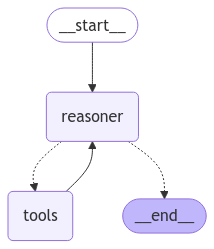

In [8]:
# Graph
builder = StateGraph(MessagesState)

# Add nodes
builder.add_node("reasoner", reasoner)
builder.add_node("tools", ToolNode(tools)) # for the tools

# Add edges
builder.add_edge(START, "reasoner")
builder.add_conditional_edges(
    "reasoner",
    # If the latest message (result) from node reasoner is a tool call -> tools_condition routes to tools
    # If the latest message (result) from node reasoner is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "reasoner")
react_graph = builder.compile()

# Display the graph
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

In [27]:
messages = [HumanMessage(content="what is Macbook price now? what's Macbook price if discount 30%?")]
messages = react_graph.invoke({"messages": messages})

In [28]:
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

what is Macbook price now? what's Macbook price if discount 30%?
================================== Ai Message ==================================
Tool Calls:
  divide (b2f4425a-1ed6-4a53-a358-7605eec04a75)
 Call ID: b2f4425a-1ed6-4a53-a358-7605eec04a75
  Args:
    a: Macbook current price
    b: 100
  multiply (b4b016a5-427d-4121-8d66-c60dac09306e)
 Call ID: b4b016a5-427d-4121-8d66-c60dac09306e
  Args:
    a: Macbook current price
    b: 0.7
  duckduckgo_search (90ba6707-9488-4ab1-a451-d55bc4ec3702)
 Call ID: 90ba6707-9488-4ab1-a451-d55bc4ec3702
  Args:
    query: Macbook current price
================================= Tool Message =================================
Name: divide

Error: 1 validation error for divide
a
  Input should be a valid integer, unable to parse string as an integer [type=int_parsing, input_value='Macbook current price', input_type=str]
    For further information visit https://error

# Add yahoo

Planer > human feedback > node for task > review > heman feedback > reprot

In [8]:
from typing import TypedDict, Annotated, Sequence
import operator
from langchain_core.messages import BaseMessage


class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]

In [ ]:
from langchain_community.tools import DuckDuckGoSearchRun

tools = [DuckDuckGoSearchRun()]

In [ ]:
from langgraph.prebuilt import ToolInvocation
import json
from langchain_core.messages import FunctionMessage
from langgraph.prebuilt import ToolExecutor

from langchain_community.chat_models import ChatOllama
from langchain.prompts import PromptTemplate

In [6]:
from langchain_core.prompts import PromptTemplate

# create the prompt
prompt_template: str = """/
You are a vehicle mechanic, give responses to the following
question: {question}. Do not use technical words, give easy
to understand responses.
"""

prompt = PromptTemplate.from_template(template=prompt_template)

# format the prompt to add variable values
prompt_formatted_str: str = prompt.format(
    question="Why won't a vehicle start on ignition?")


In [7]:
print(prompt_formatted_str)

/
You are a vehicle mechanic, give responses to the following
question: Why won't a vehicle start on ignition?. Do not use technical words, give easy
to understand responses.

